### Import Libraries and set random seed

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Set Random Number Seed
np.random.seed(112)

### Define helper methods

In [2]:
def load_data(filename):
    data = pd.read_excel(filename)
    print("Loaded data with shape: ", data.shape)
    
    # Drop the subject column since its not used and contains non-numeric data
    return data.drop('Subject', axis=1)

In [3]:
def filter_data(data, columns=None, include_control=True, combine_p_groups=False):
    df = data.copy()
    
    if not include_control:
        df = df[df.GroupID!=0]
        
    if columns:
        df = df[columns]

    if combine_p_groups:
        df.loc[df['GroupID'] != 0, 'GroupID'] = 1 

    return df

In [4]:
def resample_data(df):
    df_control =df[df.GroupID==0]  #246
    df_park = df[df.GroupID==1] #399
    df_msa = df[df.GroupID==2]  #52
    df_psp = df[df.GroupID==3]  #55

    max_length = max([len(df_park), len(df_msa), len(df_psp), len(df_control)])

    if len(df_control) > 0:
        df_control = resample(df_control, replace=True, n_samples=max_length, random_state=3)
    if len(df_msa) > 0:
        df_msa = resample(df_msa, replace=True, n_samples=max_length, random_state=1)
    if len(df_psp) > 0:
        df_psp = resample(df_psp, replace=True, n_samples=max_length, random_state=2)

    return pd.concat([df_control, df_park, df_msa, df_psp])


In [5]:
def split_x_y_data(df, ylabel="GroupID"):
    x_cols = [col for col in df.columns if col != ylabel]
    Xd = pd.DataFrame(df, columns= x_cols)
    Yd = df[ylabel]
    return Xd, Yd

In [6]:
def standardize_data(X_train, X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    return X_train_std, X_test_std

In [7]:
def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### All Groups, 7 Regions and UPDRS, Resampled

In [8]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Only grab the columns of interest.  TODO: Replace with list derived from feature selection
columns_of_interest = ["GroupID","SCP_FW","MCP_FW","Putamen_FA","Caudate_FA","STN_FW", "RN_FW", "Thalamus_FA", "UPDRS"]
filtered_data = filter_data(data, columns=columns_of_interest)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.719 (+/-0.075) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.575 (+/-0.064) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.537 (+/-0.044) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.508 (+/-0.047) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.512 (+/-0.052) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.903 (+/-0.053) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.738 (+/-0.063) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.569 (+/-0.054) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.509 (+/-0.051) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.512 (+/-0.044) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.934 (+/-0.036) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.874 (+/-0.038) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.768 (+/-0.080) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'

### All Groups, All Data, Resampled

In [9]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.719 (+/-0.075) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.575 (+/-0.064) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.537 (+/-0.044) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.508 (+/-0.047) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.512 (+/-0.052) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.903 (+/-0.053) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.738 (+/-0.063) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.569 (+/-0.054) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.509 (+/-0.051) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.512 (+/-0.044) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.934 (+/-0.036) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.874 (+/-0.038) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.768 (+/-0.080) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'

### Control vs. All Parkinsons, All Data, Resampled

In [10]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Combine Parkinson's Groups
filtered_data = filter_data(data, combine_p_groups=True)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.960 (+/-0.068) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.959 (+/-0.062) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.949 (+/-0.042) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.948 (+/-0.040) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.948 (+/-0.036) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.959 (+/-0.065) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.958 (+/-0.051) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.947 (+/-0.052) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.949 (+/-0.050) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.947 (+/-0.031) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.959 (+/-0.065) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.955 (+/-0.046) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.946 (+/-0.056) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.949 (+/

### Ignore Controls, All Data, Resampled

In [ ]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Ignore the Control Group
filtered_data = filter_data(data, include_control=False)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.980 (+/-0.030) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.825 (+/-0.064) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.645 (+/-0.076) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.554 (+/-0.080) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.534 (+/-0.068) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.985 (+/-0.023) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.905 (+/-0.057) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.786 (+/-0.108) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.582 (+/-0.093) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.557 (+/-0.086) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.985 (+/-0.023) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.918 (+/-0.064) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.907 (+/-0.064) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### Ignore Controls, 7 Regions and UPDRS, Resampled

In [ ]:
# Load the excel file
data = load_data("real_data2.xlsx")

# Only grab the columns of interest.  TODO: Replace with list derived from feature selection
columns_of_interest = ["GroupID","SCP_FW","MCP_FW","Putamen_FA","Caudate_FA","STN_FW", "RN_FW", "Thalamus_FA", "UPDRS"]
filtered_data = filter_data(data, columns=columns_of_interest, include_control=False)

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(filtered_data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# standardize the data
X_train_std, X_test_std = standardize_data(X_train, X_test)

# Perform a grid search to find best SVC model
svm_grid_search(X_train, X_test, y_train, y_test)

Loaded data with shape:  (746, 39)
# Tuning hyper-parameters for f1



## PCA

Loaded data with shape:  (746, 39)


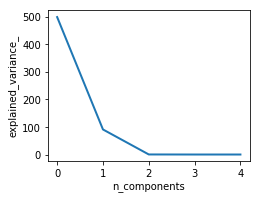

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import decomposition

# Load the excel file
data = load_data("real_data2.xlsx")

# Resample the data so that there are even numbers of each label
resampled_data = resample_data(data)

# Split predictor and response data
X, y = split_x_y_data(resampled_data)

pca = decomposition.PCA(n_components=5)

# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()


In [19]:
pca.explained_variance_

array([4.99353486e+02, 9.10251065e+01, 2.40889687e-01, 2.78097025e-02,
       1.38429260e-02])